<a href="https://www.kaggle.com/code/alkatraz/explaining-prediction-using-lime?scriptVersionId=136789253" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import shap

import pandas as pd
import numpy as np
import missingno as msno

# visuallization
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

#Machine Learning
## model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
## tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# import Scaling Model
from sklearn.preprocessing import StandardScaler ## All features have a normal distribution of 0 mean and 1 variance.
from sklearn.preprocessing import MinMaxScaler ## Makes all features have data values between 0 and 1.
from sklearn.preprocessing import MaxAbsScaler ## Makes the absolute value of all features lie between 0 and 1.
from sklearn.preprocessing import RobustScaler
## RobustScaler is similar to StandardScaler.
## However, StandardScaler uses mean and variance, while RobustScaler uses median and quartile.
from sklearn.preprocessing import Normalizer

## for splitting data
from sklearn.model_selection import train_test_split

# for explanation
from lime import lime_tabular


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-performance-in-mathematics/exams.csv


In [2]:
df = pd.read_csv("/kaggle/input/student-performance-in-mathematics/exams.csv")
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86
...,...,...,...,...,...,...,...,...
995,male,group C,some college,standard,none,77,77,71
996,male,group C,some college,standard,none,80,66,66
997,female,group A,high school,standard,completed,67,86,86
998,male,group E,high school,standard,none,80,72,62


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [4]:
df['total_marks'] = (df['math score'] + df['reading score'] + df['writing score'])
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total_marks
0,female,group D,some college,standard,completed,59,70,78,207
1,male,group D,associate's degree,standard,none,96,93,87,276
2,female,group D,some college,free/reduced,none,57,76,77,210
3,male,group B,some college,free/reduced,none,70,70,63,203
4,female,group D,associate's degree,standard,none,83,85,86,254
...,...,...,...,...,...,...,...,...,...
995,male,group C,some college,standard,none,77,77,71,225
996,male,group C,some college,standard,none,80,66,66,212
997,female,group A,high school,standard,completed,67,86,86,239
998,male,group E,high school,standard,none,80,72,62,214


In [5]:
from math import ceil
df['avg_marks'] = (df['total_marks'] / 3).apply(ceil)
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total_marks,avg_marks
0,female,group D,some college,standard,completed,59,70,78,207,69
1,male,group D,associate's degree,standard,none,96,93,87,276,92
2,female,group D,some college,free/reduced,none,57,76,77,210,70
3,male,group B,some college,free/reduced,none,70,70,63,203,68
4,female,group D,associate's degree,standard,none,83,85,86,254,85
...,...,...,...,...,...,...,...,...,...,...
995,male,group C,some college,standard,none,77,77,71,225,75
996,male,group C,some college,standard,none,80,66,66,212,71
997,female,group A,high school,standard,completed,67,86,86,239,80
998,male,group E,high school,standard,none,80,72,62,214,72


In [6]:
# define a function to assign grades based on the percentage
def assign_grade(score):
    if score >= 80:
        return 'A+'
    elif score >= 70:
        return 'A'
    elif score >= 60:
        return 'B'
    elif score >= 50:
        return 'C'
    elif score >= 40:
        return 'D'
    else:
        return 'F'

In [7]:
df['grade'] = df['avg_marks'].apply(assign_grade)
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total_marks,avg_marks,grade
0,female,group D,some college,standard,completed,59,70,78,207,69,B
1,male,group D,associate's degree,standard,none,96,93,87,276,92,A+
2,female,group D,some college,free/reduced,none,57,76,77,210,70,A
3,male,group B,some college,free/reduced,none,70,70,63,203,68,B
4,female,group D,associate's degree,standard,none,83,85,86,254,85,A+
...,...,...,...,...,...,...,...,...,...,...,...
995,male,group C,some college,standard,none,77,77,71,225,75,A
996,male,group C,some college,standard,none,80,66,66,212,71,A
997,female,group A,high school,standard,completed,67,86,86,239,80,A+
998,male,group E,high school,standard,none,80,72,62,214,72,A


In [8]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score', 'total_marks', 'avg_marks', 'grade'],
      dtype='object')

# Distribution of scores

In [9]:
features = ["gender", "race/ethnicity", "parental level of education", "lunch",
       "test preparation course"]
score_columns = ["math score", "reading score",
       "writing score", "avg_marks"]
def bias_col_scr(scr_type):
    fig, ax = plt.subplots(2, 3, figsize=(20,8))
    for i, feature in enumerate(features):
        row = i // 3
        col = i % 3
        sns.kdeplot(df[scr_type], color='#e35f62', fill=True, label="score", ax=ax[row][col])
        for value in df[feature].value_counts().index:
            sns.kdeplot(df[df[feature] == value][scr_type], fill=True, label=value, ax=ax[row][col])
        ax[row][col].legend()
        ax[row][col].set_title("distribution of <"+scr_type+"> by |-"+feature)

    plt.show()


<< math score >>.


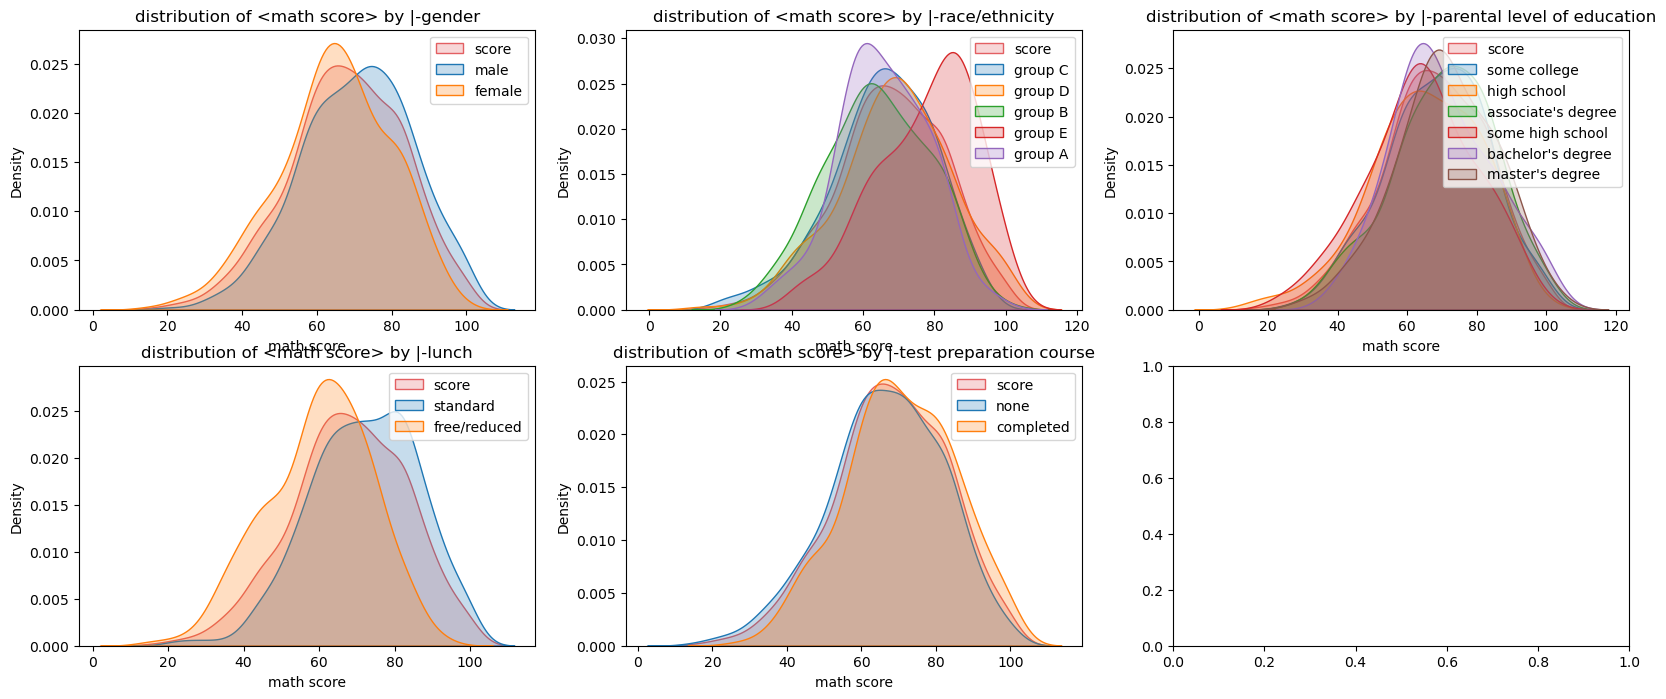


<< reading score >>.


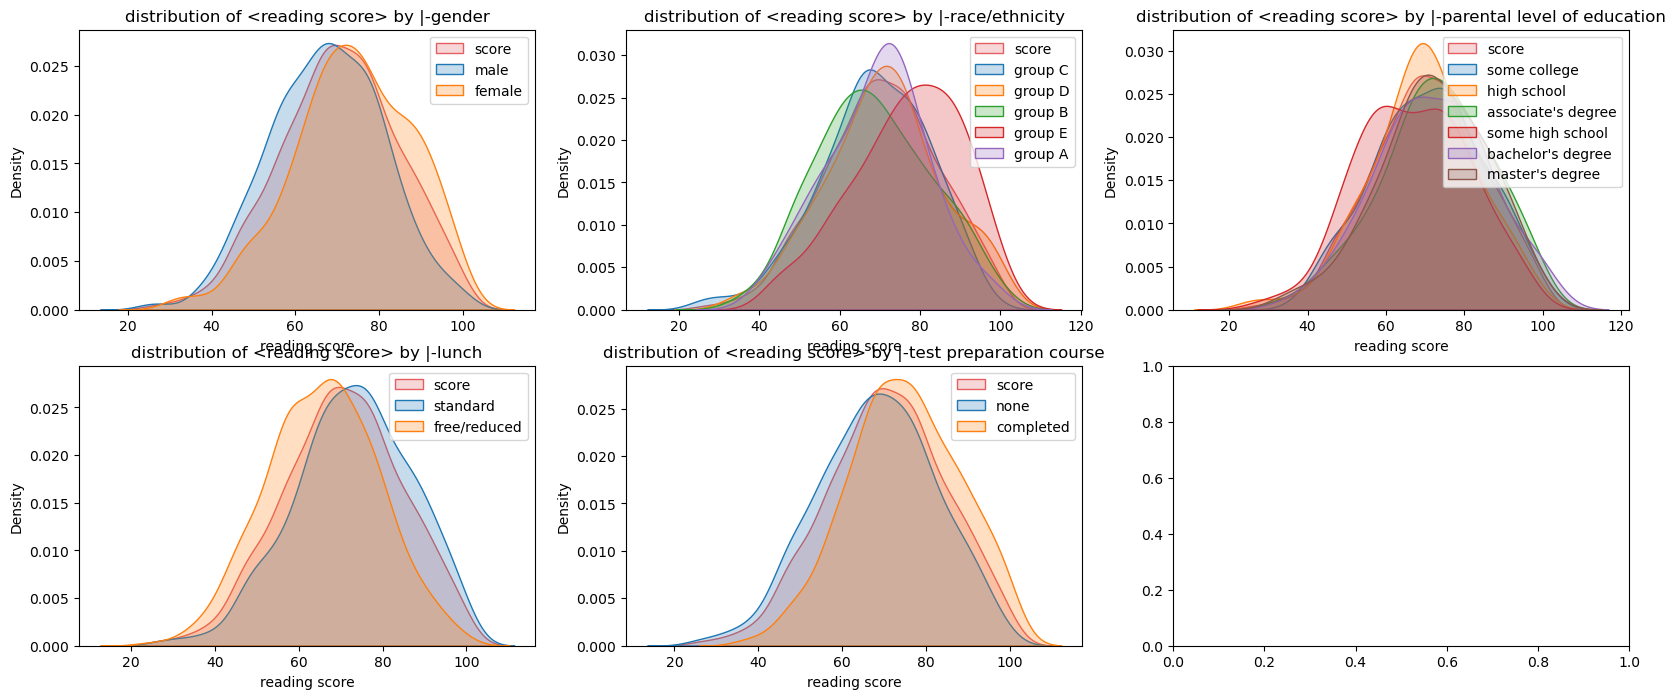


<< writing score >>.


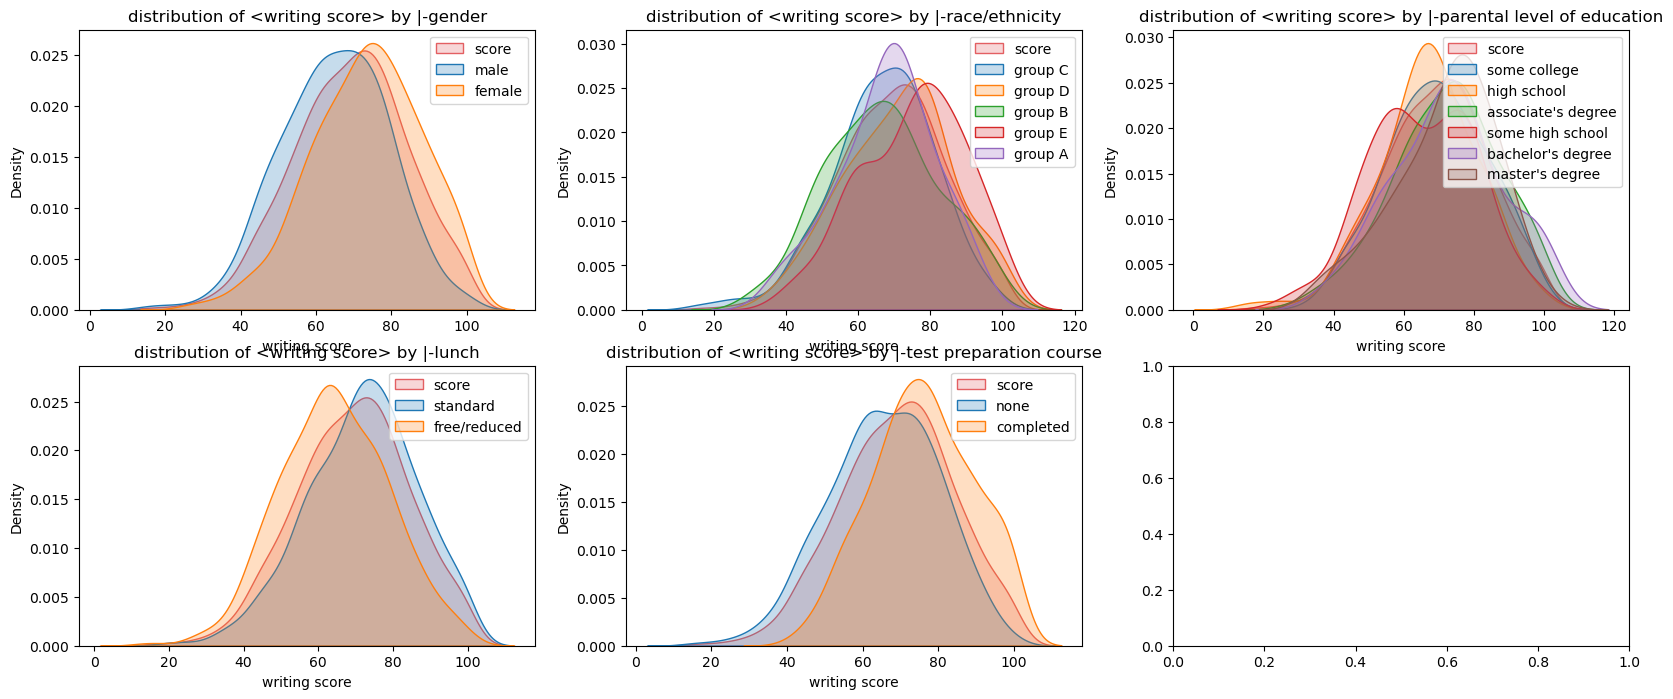


<< avg_marks >>.


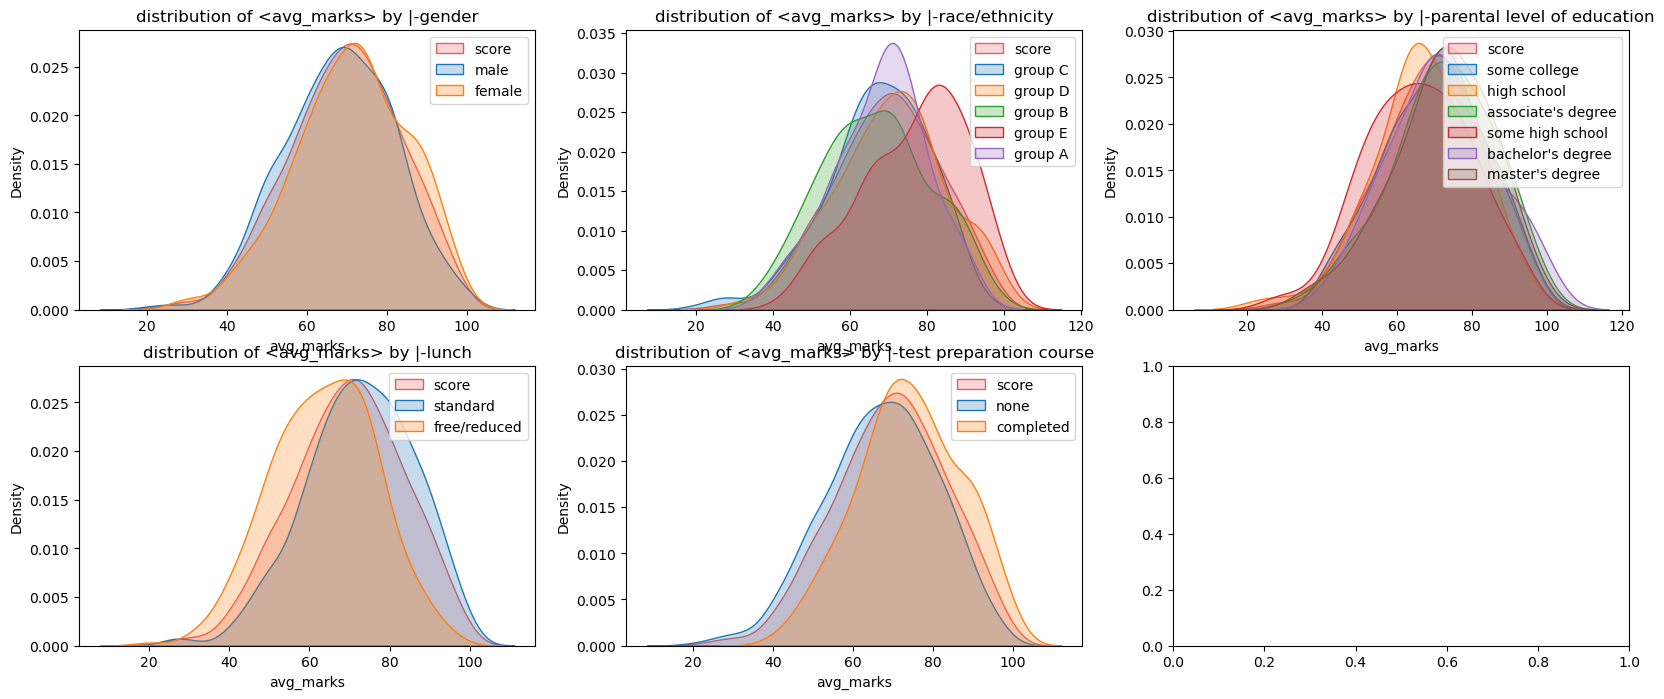

In [10]:
for x in score_columns:
    print("<<", x , ">>.")
    bias_col_scr(x)
    print()

# Score types of each columns

In [11]:
features = ["gender", "race/ethnicity", "parental level of education", "lunch",
       "test preparation course"]

def bias_col_scr_2(scr_type):
    fig, ax = plt.subplots(2, 3, figsize=(15,8))
    ax = ax.flatten()
    for i, feature in enumerate(features):
        print("")
        print("<",feature,">")
        x = []
        y = []
        for j in df[feature].value_counts().index:
            print(j, ": ", np.mean(df[df[feature]==j][scr_type].values))
            x.append(j)
            y.append(np.mean(df[df[feature]==j][scr_type].values))
        plt.sca(ax[i])
        plt.bar(x, y, color='#e35f62')
        for b in range(len(x)):
            height = y[b]
            plt.text(x[b], height + 0.5, '%.1f' % height, ha='center', va='bottom', size=12)
        plt.ylim(60, 80)
        plt.title("average "+scr_type+" by "+feature)
    plt.tight_layout()
    plt.show()

<< math score >>

< gender >
male :  70.75
female :  64.77439024390245

< race/ethnicity >
group C :  65.51083591331269
group D :  68.87937743190662
group B :  64.07070707070707
group E :  77.42657342657343
group A :  65.69620253164557

< parental level of education >
some college :  68.64285714285714
high school :  65.38139534883722
associate's degree :  70.34803921568627
some high school :  64.19774011299435
bachelor's degree :  69.86666666666666
master's degree :  71.02666666666667

< lunch >
standard :  71.88484848484849
free/reduced :  59.9

< test preparation course >
none :  66.48628048780488
completed :  70.33430232558139


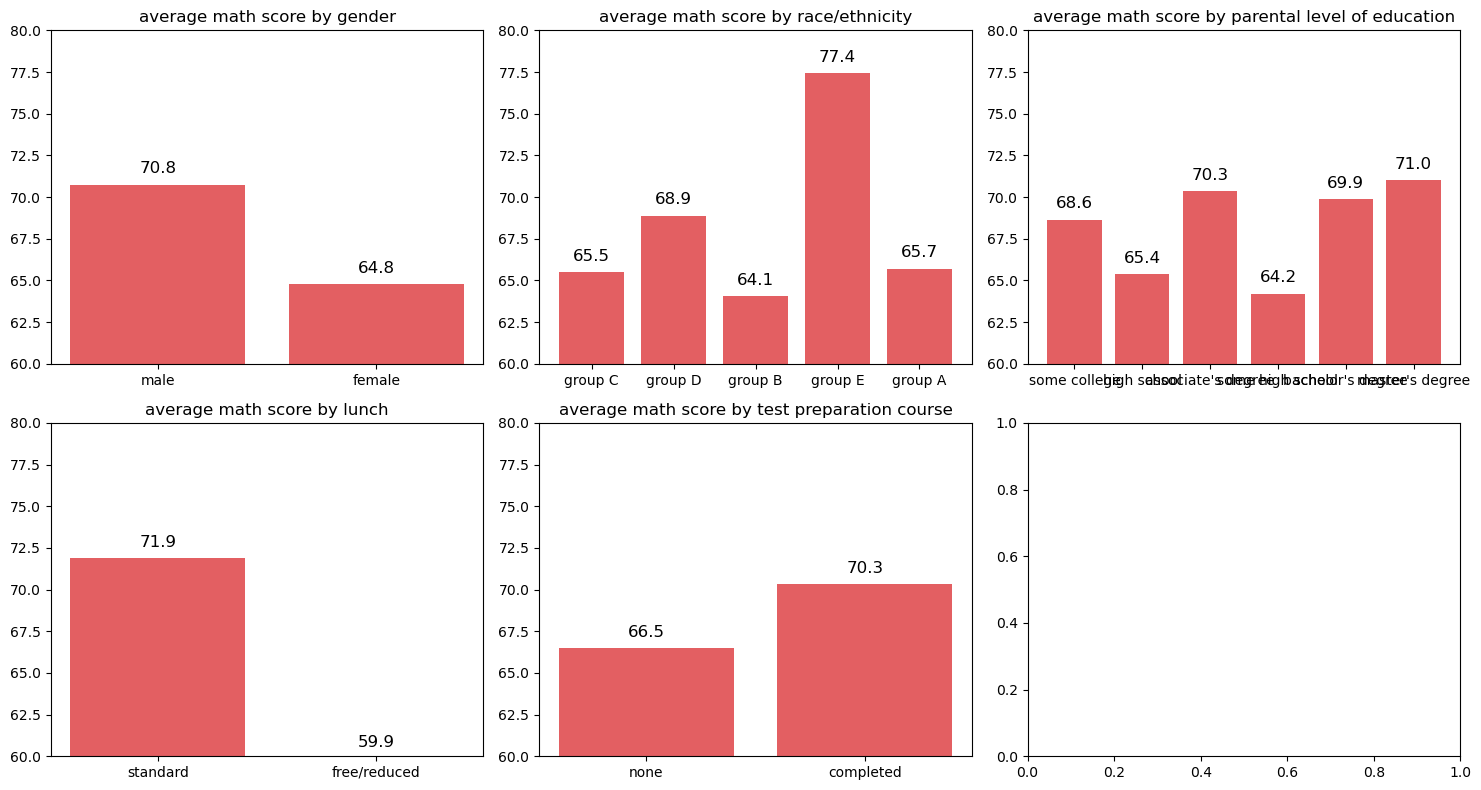


<< reading score >>

< gender >
male :  67.38779527559055
female :  73.47357723577235

< race/ethnicity >
group C :  68.60990712074303
group D :  70.92996108949416
group B :  68.53030303030303
group E :  76.61538461538461
group A :  69.20253164556962

< parental level of education >
some college :  70.94196428571429
high school :  69.22325581395349
associate's degree :  72.6470588235294
some high school :  66.94350282485875
bachelor's degree :  71.81904761904762
master's degree :  71.97333333333333

< lunch >
standard :  72.82424242424243
free/reduced :  65.64117647058823

< test preparation course >
none :  68.10365853658537
completed :  74.72674418604652


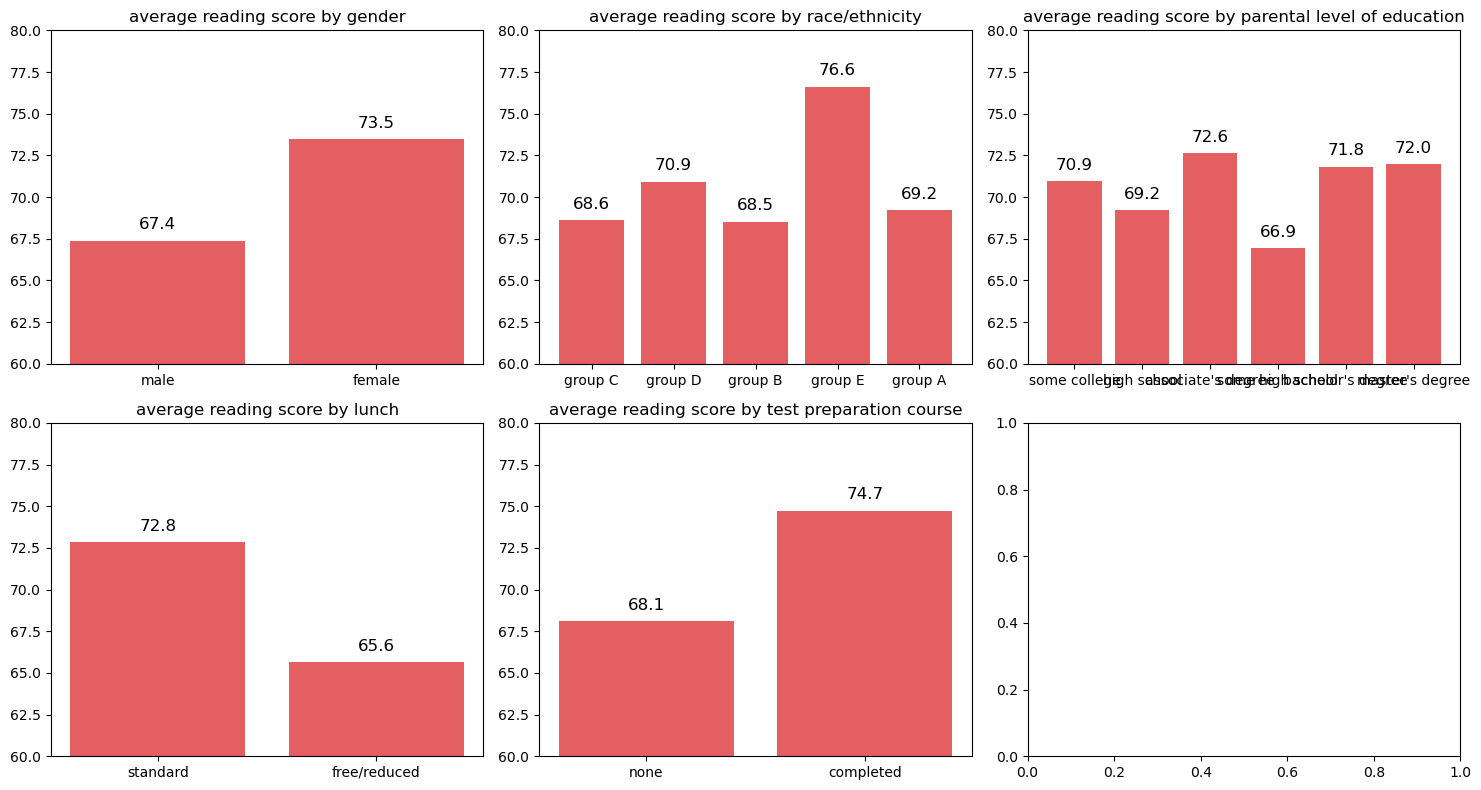


<< writing score >>

< gender >
male :  64.97637795275591
female :  73.4390243902439

< race/ethnicity >
group C :  66.80495356037152
group D :  71.05836575875486
group B :  66.71717171717172
group E :  75.03496503496504
group A :  67.84810126582279

< parental level of education >
some college :  69.47321428571429
high school :  66.77209302325582
associate's degree :  72.03921568627452
some high school :  65.29378531073446
bachelor's degree :  72.26666666666667
master's degree :  71.74666666666667

< lunch >
standard :  71.66666666666667
free/reduced :  64.23529411764706

< test preparation course >
none :  65.64329268292683
completed :  75.80813953488372


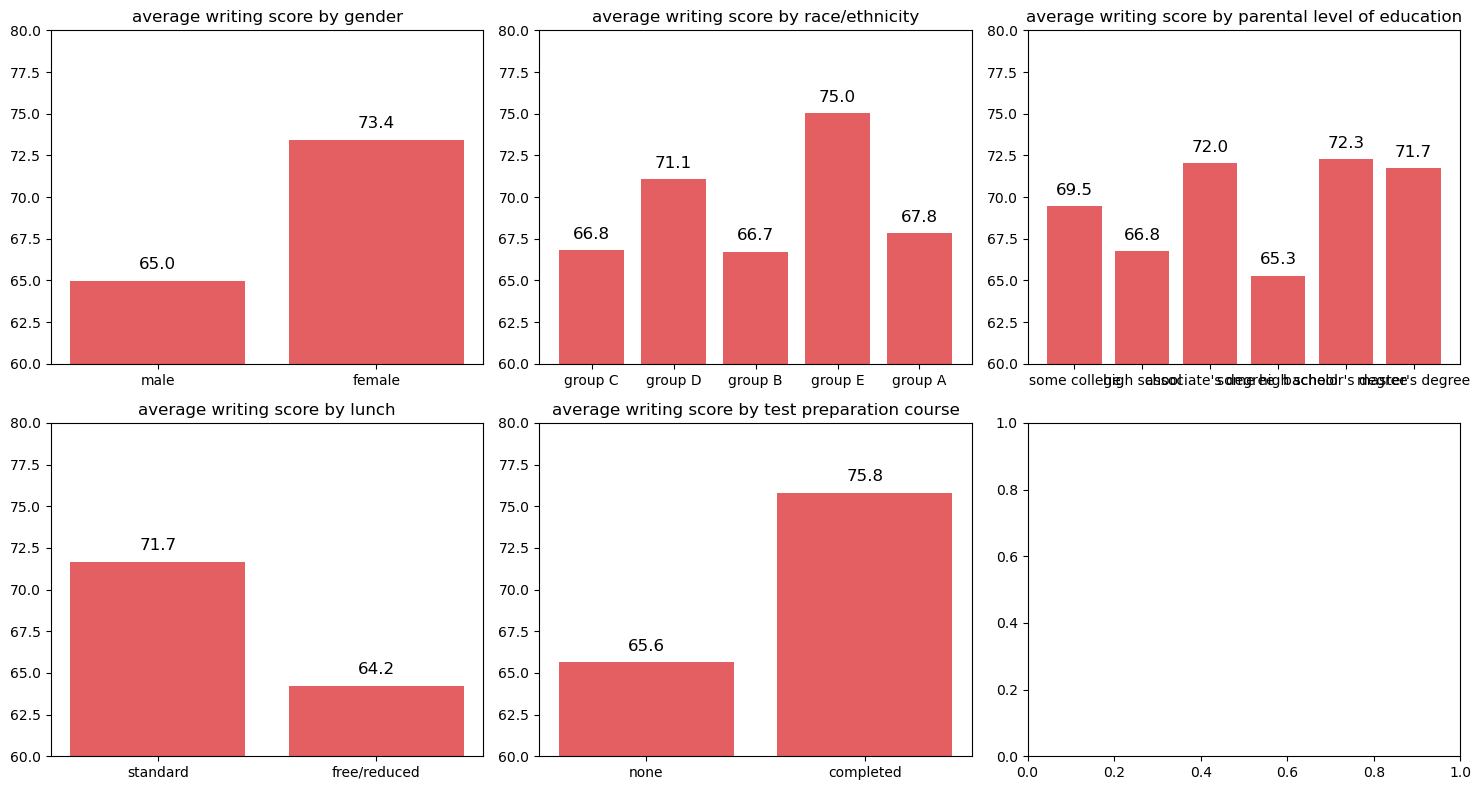


<< avg_marks >>

< gender >
male :  68.03543307086615
female :  70.88617886178862

< race/ethnicity >
group C :  67.30650154798762
group D :  70.57976653696498
group B :  66.78282828282828
group E :  76.72027972027972
group A :  67.9113924050633

< parental level of education >
some college :  69.98660714285714
high school :  67.46046511627907
associate's degree :  72.0
some high school :  65.82485875706215
bachelor's degree :  71.65714285714286
master's degree :  71.92

< lunch >
standard :  72.44545454545455
free/reduced :  63.6

< test preparation course >
none :  67.07469512195122
completed :  73.94476744186046


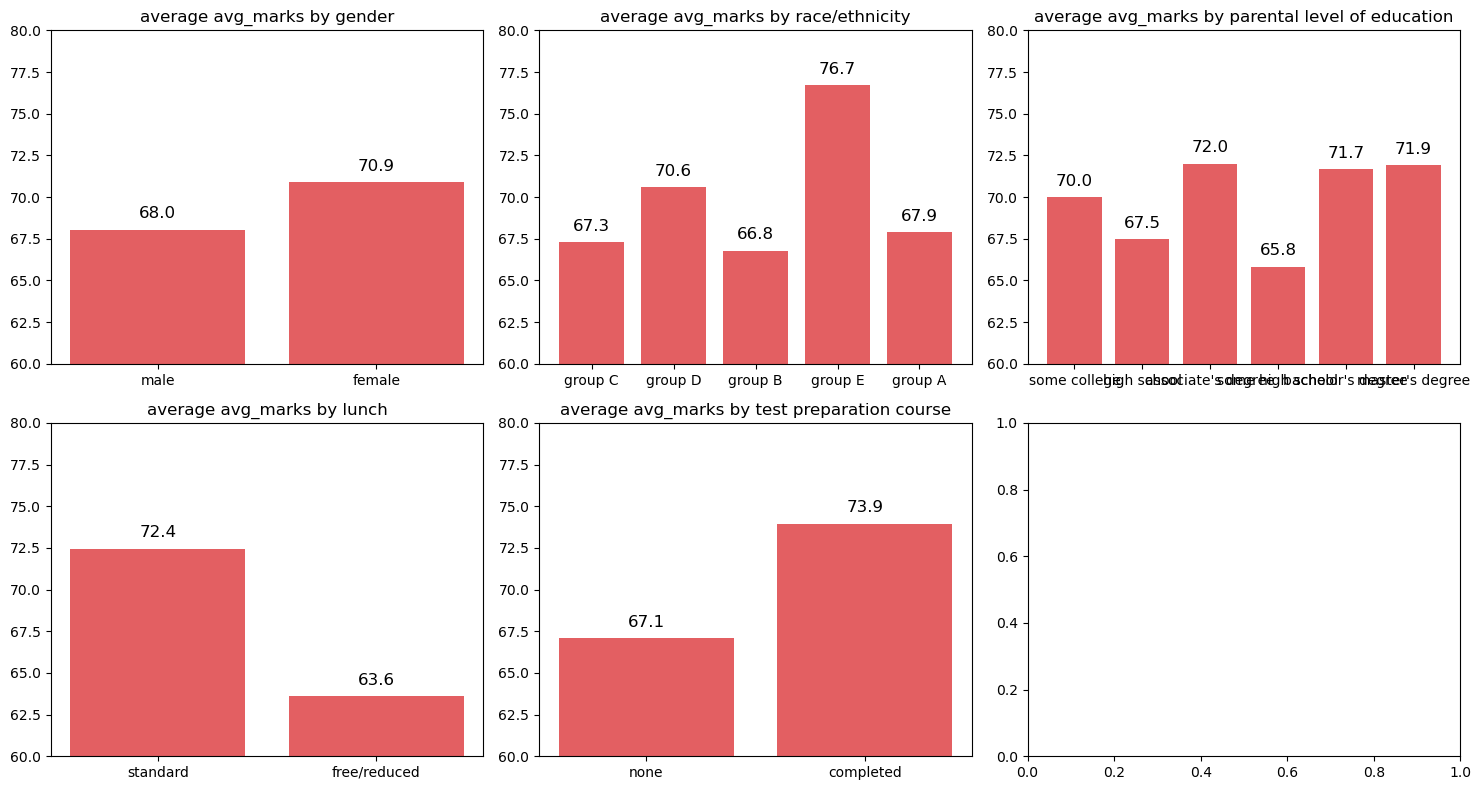

In [12]:
for x in score_columns:
    print("<<", x , ">>")
    bias_col_scr_2(x)
    print()

# Feature Engineering
Converting all attributive features to numerical ones

In [13]:
gender_mapping = {"male":0, "female":1}
race_mapping = {"group B":0.2, 
                "group C":0.4, 
                "group A":0.6, 
                "group D":0.8, 
                "group E":1, 
               }

degree_mapping = {
    "some high school" : 0,
    "high school" : 0.2,
    "some college" : 0.4,
    "bachelor's degree" : 0.6,
    "master's degree" : 0.8,
    "associate's degree" :1
}

lunch_mapping = {
    "standard" :  1,
    "free/reduced" : 0
}

test_mapping = {
    "none": 0,
    "completed": 1
}

df["gender"] = df["gender"].map(gender_mapping)
df["race/ethnicity"] = df["race/ethnicity"].map(race_mapping)
df["parental level of education"] = df["parental level of education"].map(degree_mapping)
df["lunch"] = df["lunch"].map(lunch_mapping)
df["test preparation course"] = df["test preparation course"].map(test_mapping)


In [14]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total_marks,avg_marks,grade
0,1,0.8,0.4,1,1,59,70,78,207,69,B
1,0,0.8,1.0,1,0,96,93,87,276,92,A+
2,1,0.8,0.4,0,0,57,76,77,210,70,A
3,0,0.2,0.4,0,0,70,70,63,203,68,B
4,1,0.8,1.0,1,0,83,85,86,254,85,A+


Now map the output

In [15]:
grade_mapping = {
    "A+":0,
    "A": 1,
    "B": 2,
    "C": 3,
    "D": 4,
    "F": 5
}

df["grade"] = df["grade"].map(grade_mapping)

In [16]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total_marks,avg_marks,grade
0,1,0.8,0.4,1,1,59,70,78,207,69,2
1,0,0.8,1.0,1,0,96,93,87,276,92,0
2,1,0.8,0.4,0,0,57,76,77,210,70,1
3,0,0.2,0.4,0,0,70,70,63,203,68,2
4,1,0.8,1.0,1,0,83,85,86,254,85,0


Split the feature and output columns

In [17]:
X = df.iloc[:,:-1]
Y = df.iloc[:, -1]

In [18]:
X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total_marks,avg_marks
0,1,0.8,0.4,1,1,59,70,78,207,69
1,0,0.8,1.0,1,0,96,93,87,276,92
2,1,0.8,0.4,0,0,57,76,77,210,70
3,0,0.2,0.4,0,0,70,70,63,203,68
4,1,0.8,1.0,1,0,83,85,86,254,85


In [19]:
Y.head()

0    2
1    0
2    1
3    2
4    0
Name: grade, dtype: int64

In [20]:
d_m = []
d_r = []
d_w = []
d_t = []
d_a = []
print(X["math score"][0] /100)
for i in range(len(X)):
    d_m.append(X["math score"][i] /100) 
    d_r.append(X["reading score"][i] /100)
    d_w.append(X["writing score"][i] /100)
    d_t.append(X["total_marks"][i] /300)
    d_a.append(X["avg_marks"][i] /100)
    
#     print(d_m)

# print(len(d_m))
X["math score"] = d_m
X["reading score"] = d_r
X["writing score"] = d_w
X["total_marks"] = d_t
X["avg_marks"] = d_a

for i in range(5):
    print(X["math score"][i])
#     print(d_m[i])

0.59
0.59
0.96
0.57
0.7
0.83


# Correlation

<AxesSubplot:title={'center':'Correlation of Features'}>

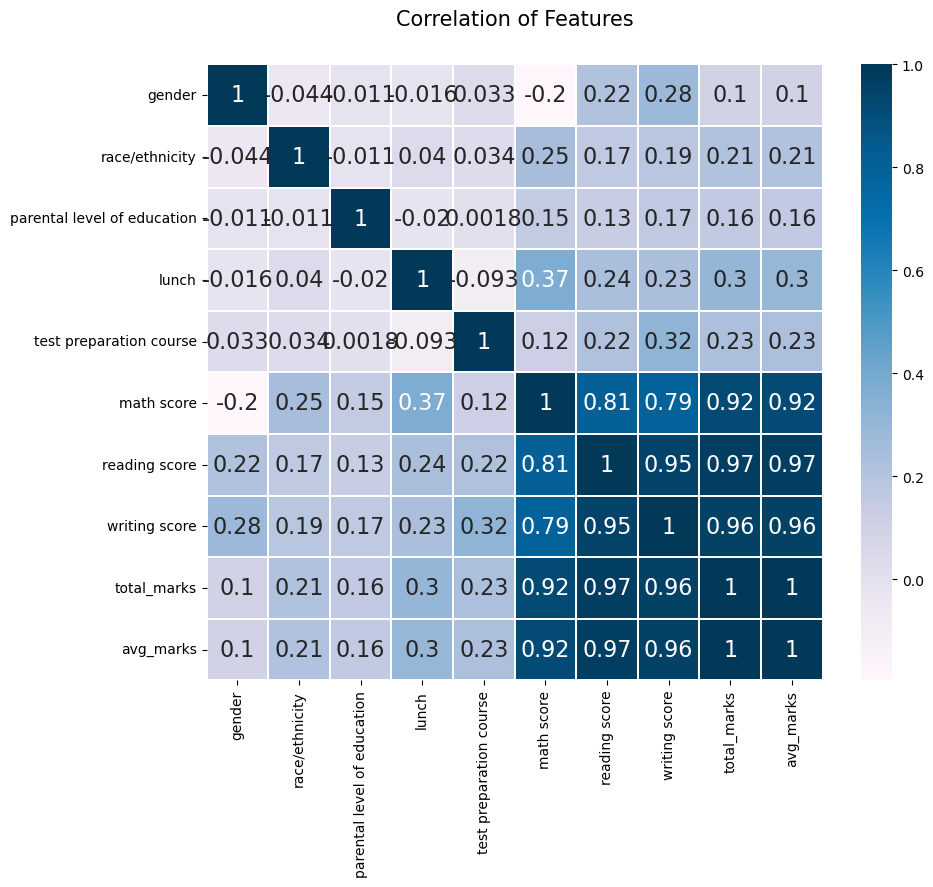

In [21]:
colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title("Correlation of Features", y = 1.05, size = 15)
sns.heatmap(X.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = True, random_state = 1004)

In [23]:
X_train.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total_marks,avg_marks
908,0,0.4,0.2,1,0,0.79,0.72,0.72,0.743333,0.75
526,0,0.2,0.8,0,0,0.65,0.65,0.62,0.640000,0.64
323,1,0.8,0.0,1,1,0.94,0.91,0.98,0.943333,0.95
507,0,0.8,0.0,0,0,0.49,0.49,0.43,0.470000,0.47
540,1,0.4,0.0,1,1,0.69,0.84,0.81,0.780000,0.78


In [24]:
Y_train.head()

908    1
526    2
323    0
507    4
540    1
Name: grade, dtype: int64

In [25]:
# Logistic Regression
logreg = LogisticRegression(max_iter=2000, 
                            solver='saga')
logreg.fit(X_train, Y_train)
logreg_pred = logreg.predict(X_test)
print("Logistic Regression Performance:")
print(classification_report(Y_test, logreg_pred, zero_division=1))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        70
           1       0.84      0.80      0.82        84
           2       0.71      0.81      0.75        74
           3       0.57      0.55      0.56        47
           4       0.38      0.15      0.21        20
           5       1.00      0.00      0.00         5

    accuracy                           0.75       300
   macro avg       0.72      0.55      0.54       300
weighted avg       0.73      0.75      0.73       300



In [26]:
# Logictic Regression with k-fold

model = LogisticRegression(max_iter=1000)

# Set up k-fold cross-validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
r2_scores = cross_val_score(model, X, Y, cv=kf, scoring='r2')
mse_scores = -cross_val_score(model, X, Y, cv=kf, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print('Cross-Validation R^2 scores:', r2_scores)
print('Mean R^2:', np.mean(r2_scores))
print('Standard Deviation of R^2:', np.std(r2_scores))

print('Cross-Validation MSE scores:', mse_scores)
print('Mean MSE:', np.mean(mse_scores))
print('Standard Deviation of MSE:', np.std(mse_scores))

Cross-Validation R^2 scores: [0.85496987 0.86141387 0.867388   0.88244514 0.84632662]
Mean R^2: 0.8625086981411997
Standard Deviation of R^2: 0.012175070200037554
Cross-Validation MSE scores: [0.21 0.24 0.22 0.21 0.26]
Mean MSE: 0.22799999999999998
Standard Deviation of MSE: 0.01939071942966532


In [27]:
# Decision Trees
dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)
dt_pred = dt.predict(X_test)
print("Decision Tree Performance:")
print(classification_report(Y_test, dt_pred))

Decision Tree Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        84
           2       1.00      1.00      1.00        74
           3       1.00      1.00      1.00        47
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00         5

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [28]:
# Random Forests
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
rf_pred = rf.predict(X_test)
print("Random Forest Performance:")
print(classification_report(Y_test, rf_pred))

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        84
           2       1.00      1.00      1.00        74
           3       1.00      1.00      1.00        47
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00         5

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [29]:
# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)
gb_pred = gb.predict(X_test)
print("Gradient Boosting Performance:")
print(classification_report(Y_test, gb_pred))

Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        84
           2       1.00      1.00      1.00        74
           3       1.00      1.00      1.00        47
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00         5

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [30]:
# Support Vector Machines
svm = SVC()
svm.fit(X_train, Y_train)
svm_pred = svm.predict(X_test)
print("Support Vector Machine Performance:")
print(classification_report(Y_test, svm_pred, zero_division=1))

Support Vector Machine Performance:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        70
           1       0.86      0.86      0.86        84
           2       0.74      0.89      0.81        74
           3       0.77      0.72      0.75        47
           4       0.71      0.60      0.65        20
           5       1.00      0.00      0.00         5

    accuracy                           0.83       300
   macro avg       0.84      0.66      0.67       300
weighted avg       0.83      0.83      0.82       300



In [31]:
# Neural Networks
mlp = MLPClassifier(max_iter=10000)
mlp.fit(X_train, Y_train)
mlp_pred = mlp.predict(X_test)
print("Neural Network Performance:")
print(classification_report(Y_test, mlp_pred, zero_division=1))

Neural Network Performance:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        70
           1       0.97      0.90      0.94        84
           2       0.92      0.96      0.94        74
           3       0.98      0.96      0.97        47
           4       0.95      1.00      0.98        20
           5       1.00      1.00      1.00         5

    accuracy                           0.96       300
   macro avg       0.96      0.97      0.97       300
weighted avg       0.96      0.96      0.96       300



In [32]:
print(X_train.columns)

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score', 'total_marks', 'avg_marks'],
      dtype='object')


In [33]:
print(len(X_train.columns))

10


**USING LIME**

In [34]:
# Get the unique class labels
class_names = list(Y.unique())
features_names = list(X_train.columns)

showed_features = 5
total_features = len(X_train.columns)

# Generate a random observation index from the test data
# observation_index = random.randint(0, len(X_test) - 1)
observation_index = 299

# Get the specific observation from the test data
observation = X_test.iloc[observation_index]

# print(X_test.iloc[3])
# print(Y_test.iloc[3], "class")

# Initialize the LIME explainer
explainer = lime_tabular.LimeTabularExplainer(X_train.values, 
                                              feature_names=features_names, 
                                              class_names=class_names, 
                                              verbose=False)

# Generate explanations
explanation = explainer.explain_instance(observation.values, 
                                         gb.predict_proba, 
                                         num_features=total_features)

# Print the explanation
explanation.show_in_notebook()  # Display the explanation in a Jupyter Notebook

# You can also access the explanation data programmatically
explanation.as_list()

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


[('avg_marks <= 0.60', -0.2948569650126342),
 ('total_marks <= 0.60', -0.06556024169999088),
 ('parental level of education <= 0.20', -0.014710589842881214),
 ('gender <= 0.00', -0.013068411473723129),
 ('reading score <= 0.61', -0.01064343384683681),
 ('0.40 < race/ethnicity <= 0.80', 0.006743293562457606),
 ('writing score <= 0.59', -0.006258245497625166),
 ('test preparation course <= 0.00', 0.005492569068611339),
 ('0.00 < lunch <= 1.00', 0.004288741559697617),
 ('math score <= 0.58', -0.004090135850099523)]

In [35]:
# def model_predict_proba(data):
#     return mlp.predict_proba(data)

In [36]:
# observation_index = 4
# observation = X_test.iloc[observation_index]
# explainer = shap.KernelExplainer(model_predict_proba, X_train)
# shap_values = explainer.shap_values(observation)

# for i, sv in enumerate(shap_values):
#     print(f"Class {i} SHAP values shape: {sv.shape}")
    
# selected_features = [0, 1, 2]  # Replace with the indices of the features you want to include

# shap_values_selected = [sv[selected_features] for sv in shap_values]
# X_test_selected = X_test.iloc[:, selected_features]

# shap.summary_plot(shap_values_selected, X_test_selected, feature_names=X_test_selected.columns)

In [37]:
# print(f"Shape of shap_values matrix: {shap_values_reshaped[0].shape}")
# print(f"Shape of X_test matrix: {X_test.shape}")
